<FONT size = 7><B>Homework_2 SVD 與影像特徵實驗<B/></FONT>

<font face="標楷體" size = 5> 學號 : 411078042  <br>
姓名 : 李翊愷 </font>

<font color=#D36010>目標</font> ： <br>
* 比較整張圖進行 svd 以及先拆分後進行 svd 再組合再一起 <br>
* 隨機取出 mnist 的圖片 <br>
* 將圖片進行壓縮 <br>
* 把圖片加密以及解密 <br>

# packages

In [1]:
# image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage import data

# math
import numpy as np
from numpy.linalg import svd
from sklearn.metrics import mean_squared_error
from skimage.transform import resize

# data
import pandas as pd
from scipy.io import loadmat

# Q1-svd 的比較

## load image
我使用在影像處理中經常使用到的 "cameraman" 來當作素材

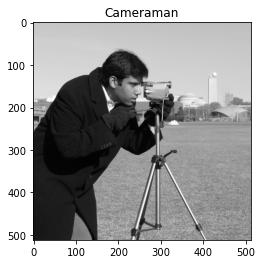

In [2]:
# load cameraman
cameraman = data.camera()
plt.imshow(cameraman, cmap='gray')
plt.title('Cameraman')
plt.show()

## def svd function
定義出函式 : <br>
* `svd_transform` : 使用 SVD 來進行轉換 <br>
$\Rightarrow$最後輸出轉換後的矩陣&rmse <br>

* `img_spilt_svd_combine` : 首先進行預處理，接著進行 SVD 轉換，然後將轉換後的矩陣結合在一起 <br>
$\Rightarrow$最後輸出轉換後的矩陣&rmse <br>

---

**補充--rmse :** <br>
這是為了要比較轉換後的圖形與原始圖形，rmse的值越大代表轉換後的結果比較差 <br>
因此會希望得到的 rmse 越小越好 <br>

In [3]:
# def svd_transform
def svd_transform(ori_img, q):
    U, E, Vt = svd(ori_img, full_matrices=False)
    trans_img = U[:, :q] @ np.diag(E[:q]) @ Vt[:q, :]

    # use rmse to test
    rmse = np.sqrt(mean_squared_error(ori_img, trans_img))

    return trans_img, rmse


# def img_spilt_svd_combine
def img_spilt_svd_combine(ori_img, q, patch):
    # get ori_img size
    height, width = ori_img.shape
    patch_height, patch_width = patch

    # split
    spilt_img = np.zeros((patch_height * patch_width,
                         (height // patch_height) * (width // patch_width)))
    k = 0
    for i in range(height // patch_height):
        for j in range(width // patch_width):
            spilt_img[:, k] = ori_img[i * patch_height: (i + 1) * patch_height, j * patch_width: (
                j + 1) * patch_width].reshape(-1, 1).flatten()
            k += 1

    # svd
    svd_img, _ = svd_transform(spilt_img, q)

    # combine(trans_img)
    trans_img = np.zeros_like(ori_img)
    k = 0
    for i in range(height // patch_height):
        for j in range(width // patch_width):
            trans_img[i * patch_height: (i + 1) * patch_height, j * patch_width: (
                j + 1) * patch_width] = svd_img[:, k].reshape(patch_height, patch_width)
            k += 1

    # use rmse to test
    rmse = np.sqrt(mean_squared_error(ori_img, trans_img))

    return trans_img, rmse

## show result
以 `cameraman` 這張圖片作為要進行 SVD 的圖片檔 <br>
其中 `q`, `patches` 可以自己定義 <br>
最後會輸出每張圖片經過 SVD 後的樣子 <br>
並且能夠藉由 `rmse` 來比較好壞 <br>

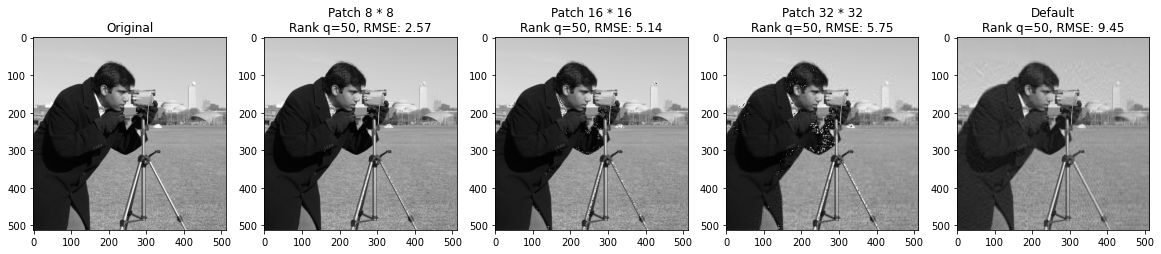

In [4]:
# show result
# basic def
cameraman = data.camera()
q = 50
patches = [(8, 8), (16, 16), (32, 32)]

# transform img
results = []
for patch_size in patches:
    trans_img, rmse = img_spilt_svd_combine(cameraman, q, patch_size)
    results.append((trans_img, rmse))

trans_img_default, rmse_default = svd_transform(cameraman, q)

# plot
plt.figure(figsize=(20, 16))

# original
plt.subplot(1, 5, 1)
plt.imshow(cameraman, cmap='gray')
plt.title('Original')

# img_spilt_svd_combine transform
for i, (trans_img, rmse) in enumerate(results, start=2):
    plt.subplot(1, 5, i)
    plt.imshow(trans_img, cmap='gray')
    plt.title(
        f'Patch {patches[i-2][0]} * {patches[i-2][1]}\nRank q={q}, RMSE: {round(rmse, 2)}')

# default svd transform
plt.subplot(1, 5, 5)
plt.imshow(trans_img_default, cmap='gray')
plt.title(f'Default\nRank q={q}, RMSE: {round(rmse_default, 2)}')

# show
plt.show()

## Q1-conclusion
先從 patch 內部的 3 張圖進行比較 : <br>
可以看到當每次分割的 patch 越小時，整體做完 svd 之後的影像會越好 <br>
不僅能從 rmse 中看出，也能夠肉眼可見的看到 <br>
尤其在圖中間袖子的部分，隨著 patch 的增加而出現更多的白色區塊 <br>

---

接著我們比較單純使用 svd 以及有先經過 patch 分割的 : <br>
從 rmse 可以看出 default 的 rmse 非常大，也就是他的轉換程度並不好 <br>
但是我們用肉眼來看時卻能夠比較完整的看出整張圖 <br>
只是整體的畫值(應該說是顏色、或是對比)降低了 <br>

# Q2-隨機取出圖片

## load mnist

In [5]:
# load mnist
mnist = loadmat("mnist-original.mat")

## def random choice number image function
定義出函式 : <br>
* `random_num_pict` : 可以放入的參數分別是 *想看到的數字*、*幾個橫列*、*幾個直行*、(*給定種子--使輸出相同*) <br>
其中有個隱藏的使用方式可以連輸出的數字都是隨機的 <br>
$\Rightarrow$最後輸出隨機的矩陣 <br>


In [6]:
# def random_num_pict
def random_num_pict(num, m, n, seed=None):
    X = mnist["data"]
    y = mnist["label"][0]

    # set random num
    if num == "random":
        num = np.random.randint(0, 10)

    # set seed
    np.random.seed(seed)

    # random choose num
    # with stable num, size = m*n
    index = np.random.choice(np.arange(sum(y == num)), replace=False, size=m*n)

    # use index to get num
    data = X[:, y == num][:, index]

    # reshape
    num_matrix = np.zeros((28*m, 28*n))
    for i in range(m):
        for j in range(n):
            num_matrix[28*i:28*(i+1), 28*j:28*(j+1)
                       ] = data[:, i*n+j].reshape(28, 28)
    return num_matrix

## show result (with seed)
輸出給定特定數字，以及給定種子的圖片 <br>

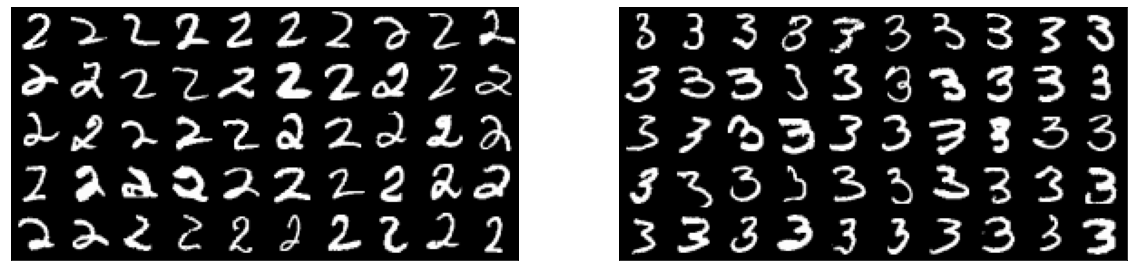

In [7]:
# show result(with seed)
# get matrix
img_list1 = random_num_pict(2, 5, 10, 10016957)
img_list2 = random_num_pict(3, 5, 10, 10016959)

# plot
plt.figure(figsize=(20, 5))
# 1st
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img_list1, cmap="gray")
# 2nd
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(img_list2, cmap="gray")

# show
plt.show()

## show result (randomly)
輸出給定數字，但不給定種子(也就是隨機產生)的圖片 <br>

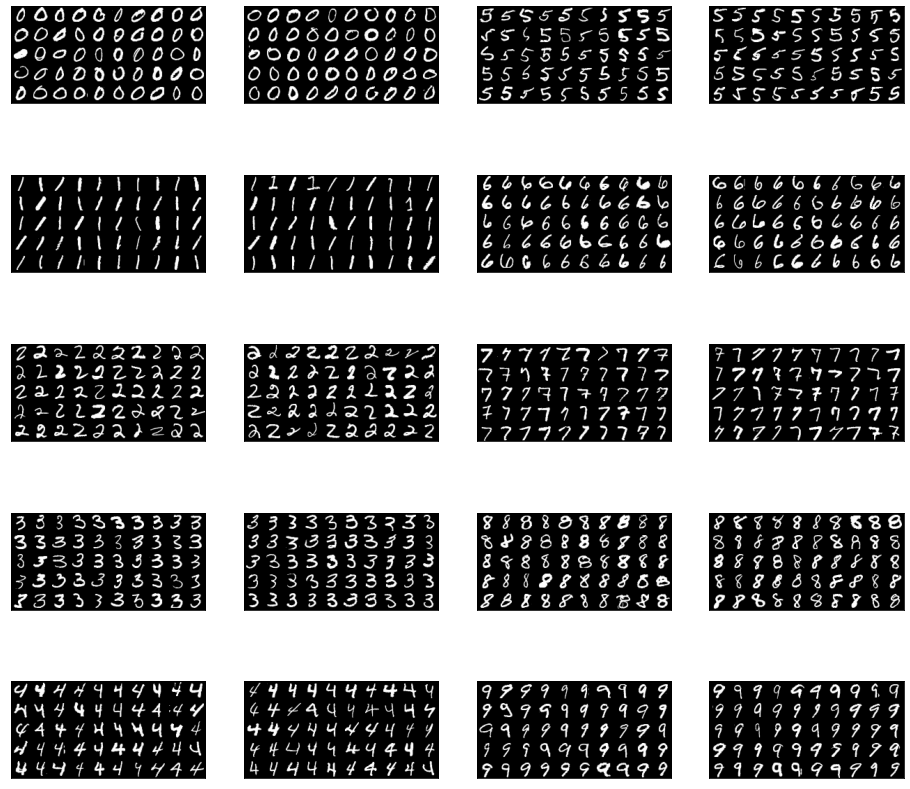

In [8]:
# show result(randomly)
fig, axes = plt.subplots(5, 4, figsize=(16, 15))

# loop
for i in range(5):
    # get matrix
    img_list_1 = random_num_pict(i, 5, 10)
    img_list_2 = random_num_pict(i, 5, 10)
    img_list_3 = random_num_pict(i+5, 5, 10)
    img_list_4 = random_num_pict(i+5, 5, 10)

    # plot
    for j, img_list in enumerate([img_list_1, img_list_2, img_list_3, img_list_4]):
        axes[i, j].imshow(img_list, cmap="gray")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# show
plt.show()

## Q2-conclusion
沒啥特別的，只是基本功

# Q3-壓縮圖片

## def show multiple svd picture
定義出函式 : <br>
* `show_multi_svd` : 需要給定原始圖片，接著放入想要看到的 q 參數(要是 list 的形式) <br>
$\Rightarrow$最後輸出很多的圖片，以及該圖片的壓縮比(compression ratio) <br>

---

**補充--compression ratio :** <br>
算法如下 : <br>
$compression \ ratio = \cfrac{pixel \cdot pixel}{2q \cdot pixel + q} = \dfrac{28 \cdot 28}{57 \cdot q}$ <br>
$compression \ ratio \ teacher = pixel \div q \div 2$ <br>

---

**花很多時間的部分 :** <br>
為了讓輸出的圖形比較好看 <br>
特別寫了一大段去美化圖片...... <br>

In [9]:
def show_multi_svd(img, q):
    # basic val
    n_q = len(q)
    
    # set subplot
    num_rows = (n_q // 5) + 1
    num_cols = min(n_q, 5)
    # 1_dim
    if num_rows == 1:
        fig, axes = plt.subplots(
            1, num_cols + 1, figsize=(5*(num_cols + 1), 4))
    # multi_dim
    else:
        fig, axes = plt.subplots(
            num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))
    remain_n_pic = (5-(n_q+1) % 5) % 5

    # plot ori_img
    if num_rows == 1:
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original')
        axes[0].axis('off')

    else:
        axes[0, 0].imshow(img, cmap='gray')
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')
    
    # plot svd transform
    pixel = 28
    for i, rank in enumerate(q, start=1):
        # 1_dim
        if num_rows == 1:
            col = i
            trans_img, _ = svd_transform(img, rank)
            comp_ratio = round((pixel*pixel)/(2 * rank * pixel + rank), 2)
            comp_ratio_teacher = round((pixel/rank/2), 2)
            axes[col].imshow(trans_img, cmap='gray')
            axes[col].set_title(
                f'SVD Rank {rank} \n compression ratio: {comp_ratio} \n compression ratio by teacher:{comp_ratio_teacher}')
            axes[col].axis('off')
        # multi_dim
        else:
            row = i // 5
            col = i % 5
            trans_img, _ = svd_transform(img, rank)
            comp_ratio = round((pixel*pixel)/(2 * rank * pixel + rank), 2)
            comp_ratio_teacher = round((pixel/rank/2), 2)
            axes[row, col].imshow(trans_img, cmap='gray')
            axes[row, col].set_title(
                f'SVD Rank {rank} \n compression ratio: {comp_ratio} \n compression ratio by teacher:{comp_ratio_teacher}')
            axes[row, col].axis('off')

    # del extra ax
    if remain_n_pic != 0 and num_rows > 1:
        col_indices = list(range(5 - remain_n_pic, 5))
        for row in range(num_rows - 1, num_rows):
            for col in col_indices:
                if num_rows == 1:
                    fig.delaxes(axes[col])
                else:
                    fig.delaxes(axes[row, col])

    # show
    plt.tight_layout()
    plt.show()

## choose the picture
隨便選出一張圖 <br>

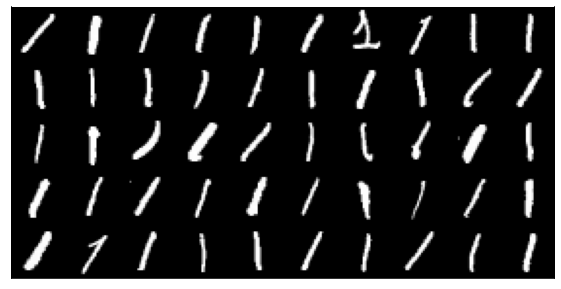

In [10]:
# show ori_pic
# get matrix
img_list = random_num_pict("random", 5, 10)

# plot
plt.figure(figsize=(20, 5))
plt.xticks([])
plt.yticks([])
plt.imshow(img_list, cmap="gray")

# show
plt.show()

## show result

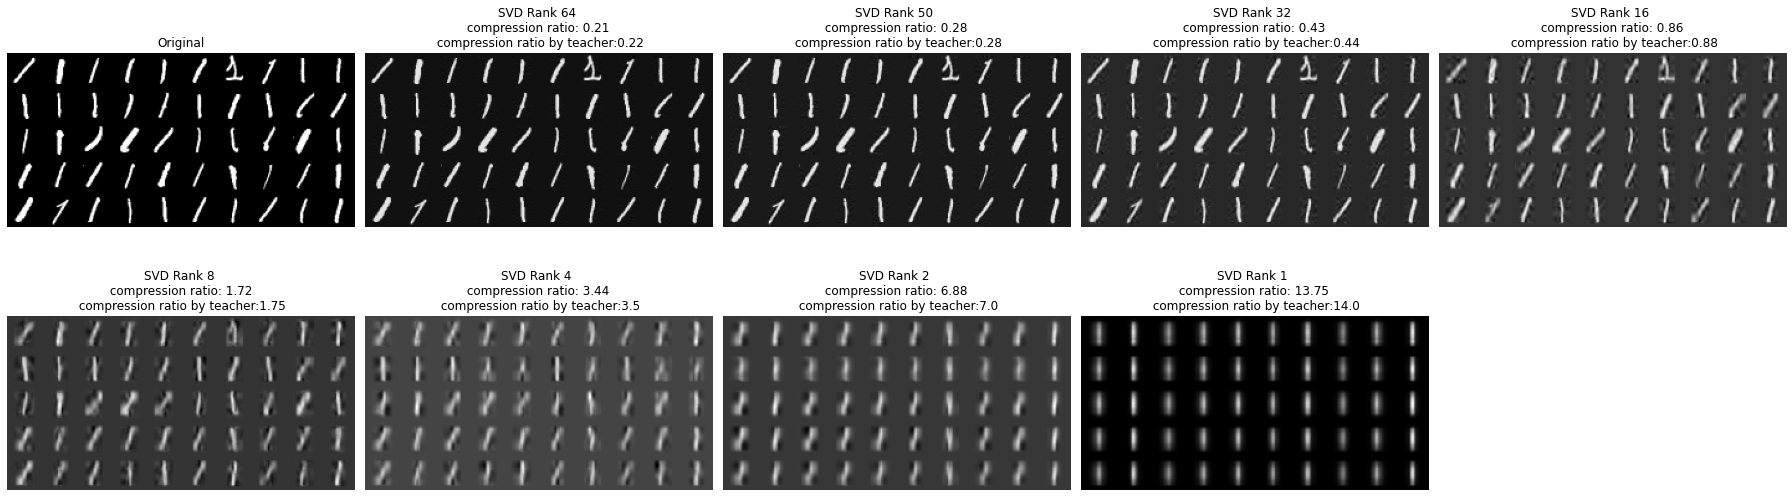

In [11]:
# show result
q_list = [64, 50, 32, 16, 8, 4, 2, 1]
show_multi_svd(img_list, q_list)

## Q3-conclusion
當 q值 越大的話輸出的圖片會與原始圖形更加接近 <br>
不過我們可以從 compression ratio 看到有些數值大於 1 有些則是小於 <br>
代表了壓縮的方式並沒有很好的效果，可能輸出的比輸入的還要大 <br>
可以發現到差不多需要取到 rank 16 才能完整的辨別出圖形 <br>
但這時 compression ratio 已經小於 1 了 <br>
因此似乎應該使用更好的方式壓縮圖片 <br>

# Q4-加密與解密
因為題目給定的這 5 張圖片是由 `allface.mat` 所加密的 <br>
因此我們的目標是利用原本的資料集(也就是`allface.mat`)還原這 5 張圖片 <br>


## load faces

In [2]:
# load data
face_data = loadmat("allFaces.mat")
en_5_img = pd.read_csv("五張加密的影像_2024.csv").values

## def functions
目的是達成加密&解密的效果 <br>
因為 $X_q = U_qZ_q \Rightarrow U^T_qX_q = Z_q$ : 這是代表被加密後的 <br>
所以 $(U^T_q)^{-1}Z_q = X_q$ : 這是代表我們要進行解密的 <br>

In [3]:
# def de_or_en_img
def de_or_en_img(img_matrix, size=(1, 1), case="de"):
    # take size's parameter
    m, n = size

    # check case in "de"、"en"
    if case not in ["de", "en"]:
        raise ValueError("Invalid value for 'case'. Must be 'de' or 'en'.")

    # take data
    data = img_matrix[:, :m * n]

    # init matrix
    final_matrix = np.zeros((192 * m, 168 * n))

    # reshape
    reshape_size = {"de": (168, 192), "en": (192, 168)}
    # loop
    for i in range(m):
        for j in range(n):
            if case == "de":
                final_matrix[i*192:(i+1)*192, j*168:(j+1)*168] = data[:, i*n+j].reshape(168, 192).T
            elif case == "en":
                final_matrix[i*192:(i+1)*192, j*168:(j+1)*168] = data[:, i*n+j].reshape(192, 168)

    # show
    plt.figure(figsize=(12 * m, 8 * n))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(final_matrix, cmap="gray")

## show random 38 picture

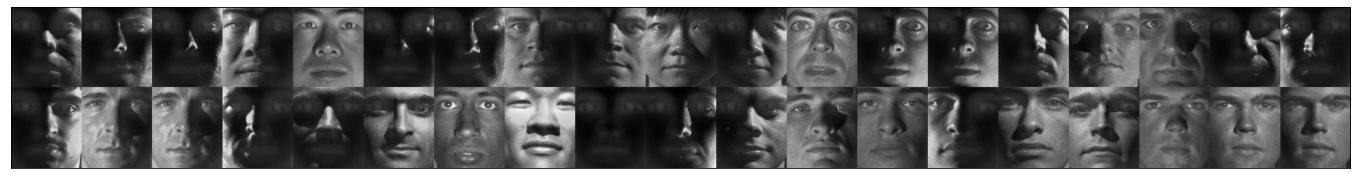

In [4]:
# people
n = face_data["person"]
faces = face_data["faces"]
nfaces = face_data["nfaces"]

# cal face mean
face_means = np.mean(faces, axis=1, keepdims=True)

# expand to same size as ori_img
avg_face = np.repeat(face_means, faces.shape[1], axis=1)
adj_face = faces - avg_face

# get random 38 face
index = np.cumsum(np.random.randint([0] * n, nfaces))
face_38 = adj_face[:, index]

# show
de_or_en_img(face_38, (2, 19), "de")


## show decrypt result

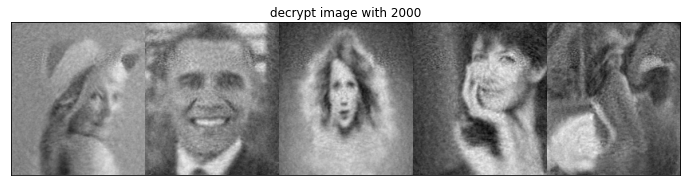

In [5]:
# result
# svd
U, _, _ = svd(adj_face, full_matrices = False)
q = 2000
U_q = U[:, :q]
X_q = U_q @ en_5_img[:q, :]
# show
de_or_en_img(X_q, (1, 5))
plt.title(f"decrypt image with {q}")
plt.show()

## adjust picture
先把圖片讀取到 <br>
接著轉成灰階圖 <br>
然後 resize <br>
最後改成命名為 img{i} 儲存 <br>

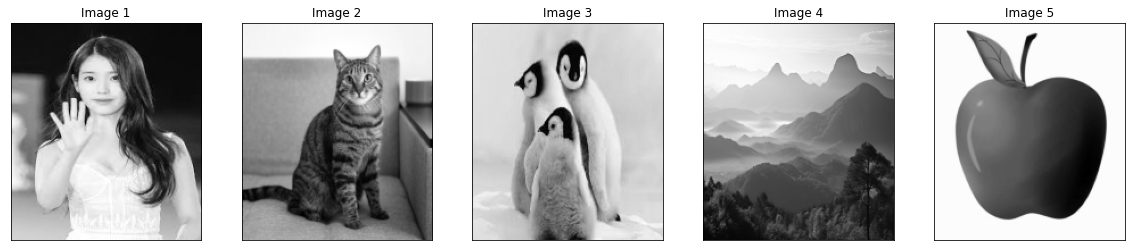

In [6]:
# adjust img
# files
files = [
    "people_1.png", "cat_1.png",
    "penguin_1.png", "view_1.png", "apple_1.png"
]

images = []
titles = []

# adjust img
for img_file in files:
    # load
    img = mpimg.imread(img_file)
    #  gray
    img = np.mean(img, axis=2)
    # resize
    resized_img = resize(img, (192, 168))
    # save
    images.append(resized_img)
    titles.append(f'Image {len(images)}')

# plot
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, (img, title) in enumerate(zip(images, titles)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    exec(f'img{i+1} = img')

plt.show()


## def encrypt & decrypt function

In [7]:
# def encrypt & decrypt
def encrypt(img):
    avgFace = img.mean(axis=1)
    X_avg = img - avgFace.reshape(-1, 1)
    U, _, _ = np.linalg.svd(X_avg, full_matrices=False)
    return U, avgFace

def decrypt(U, avgFace, img, q):
    decrypted_images = []
    for d in q:
        Xq = U[:, :d] @ (U[:, :d].T @ img)
        decrypted_images.append(Xq + avgFace.reshape(-1, 1))
    return decrypted_images

## show result

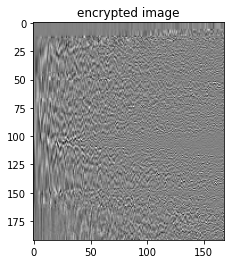

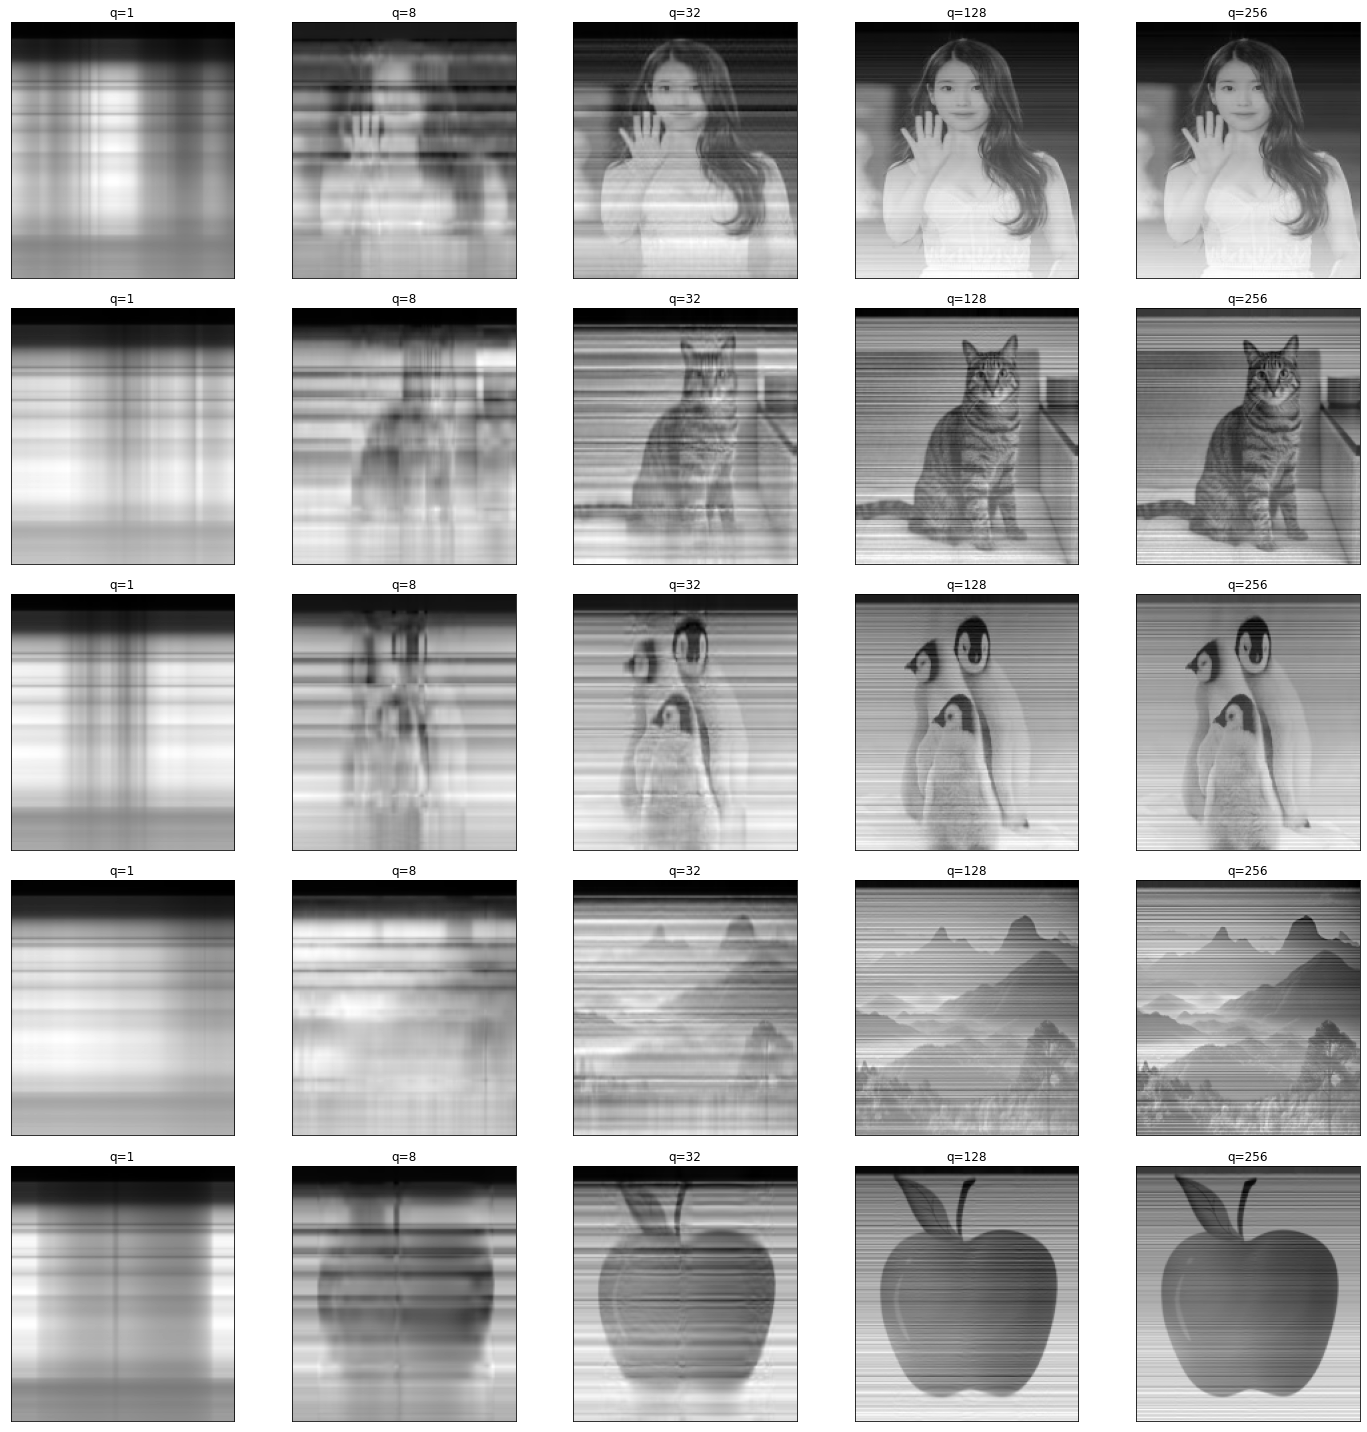

In [8]:
# result
# 使用 img1 當作加密方式
U, avgFace = encrypt(img1)
plt.imshow(U, cmap='gray')
plt.title("encrypted image")

# def q
q = [1,8,32,128, 256]

# 對所有的圖象都進行解密
plt.figure(figsize=(20, 20))
for i, j in enumerate(images):
    decrypted_images = decrypt(U, avgFace, np.array(j), q)
    for k, Xq in enumerate(decrypted_images):
        plt.subplot(len(images), len(q), (i * len(q)) + k + 1)
        plt.title('q={}'.format(q[k]))
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.imshow(Xq, cmap='gray')
        
plt.show()

## Q4-conclusion
從上圖可以看出其實就算是用人臉來進行加密最終解密時也能夠大致看出原始圖片的樣子 <br>
並且隨著 q 的增加，越能夠看出圖片原始的樣貌 <br>